# General Circulation Model (Fortran)

Here we setup and run [MITgcm](https://mitgcm.readthedocs.io/en/latest/). This
general circulation model can simulate the Ocean (as done here), Atmosphere
(plot below), and other components of the climate system accross a wide range
of scales and configurations.

In [1]:
using ClimateModels, MITgcmTools, MeshArrays, Plots, Suppressor

![fig1](https://user-images.githubusercontent.com/20276764/111042787-12377e00-840d-11eb-8ddb-64cc1cfd57fd.png)

## Setup Model

The most standard MITgcm configurations (_verification experiments_) are all readily available via `MITgcmTools.jl`'s `MITgcm_config` function.

In [2]:
MC=MITgcm_config(configuration="global_with_exf")

  ID            = 7f1354ac-8b8a-45f7-b3e4-2a9f4209776d
  model         = MITgcm
  configuration = global_with_exf
  folder        = /tmp
  log subfolder = 7f1354ac-8b8a-45f7-b3e4-2a9f4209776d/log


The `setup` function links input files to the `run/` folder (see below).

In [3]:
setup(MC)

true

Model parameters can then be accessed via `MC.inputs`.

In [4]:
MC.inputs

OrderedCollections.OrderedDict{Any, Any} with 7 entries:
  :main        => OrderedCollections.OrderedDict{Any, Any}(:PARM01=>OrderedColl…
  :cal         => OrderedCollections.OrderedDict{Any, Any}(:CAL_NML=>OrderedCol…
  :diagnostics => OrderedCollections.OrderedDict{Any, Any}(:DIAGNOSTICS_LIST=>O…
  :exf         => OrderedCollections.OrderedDict{Any, Any}(:EXF_NML_01=>Ordered…
  :gmredi      => OrderedCollections.OrderedDict{Any, Any}(Symbol("GM_PARM01 ")…
  :pkg         => OrderedCollections.OrderedDict{Any, Any}(:PACKAGES=>OrderedCo…
  :profiles    => OrderedCollections.OrderedDict{Any, Any}(:PROFILES_NML=>Order…

## Build `mitgcmuv`

The model executable `mitcmuv` is normally found in the `build/` subfolder of the selected experiment.
If `mitcmuv` is not found at this stage then it is assumed that the chosen model configuration still needs to be compiled (once, via the `build` function).
This might take a lot longer than a normal model run due to the one-time cost of compiling the model.

In [5]:
if isa(MITgcm_path,Array) #MITgcmTools > v0.1.22
	build(MC,"--allow-skip")
else
	build(MC)
end

true

## Run Model

The main model computation takes place via the `launch` function.

In [6]:
launch(MC)

MITgcm will output files in the `run/` folder incl. the standard `output.txt` file.

In [7]:
rundir=joinpath(MC.folder,string(MC.ID),"run")
fileout=joinpath(rundir,"output.txt")
readlines(fileout)

4917-element Vector{String}:
 "(PID.TID 0000.0001) "
 "(PID.TID 0000.0001) // ======================================================"
 "(PID.TID 0000.0001) //                      MITgcm UV"
 "(PID.TID 0000.0001) //                      ========="
 "(PID.TID 0000.0001) // ======================================================"
 "(PID.TID 0000.0001) // execution environment starting up..."
 "(PID.TID 0000.0001) "
 "(PID.TID 0000.0001) // MITgcmUV version:  checkpoint67s"
 "(PID.TID 0000.0001) // Build user:        runner"
 "(PID.TID 0000.0001) // Build host:        fv-az196-976"
 ⋮
 "(PID.TID 0000.0001) //          Total. Y spins =              0"
 "(PID.TID 0000.0001) //            Avg. Y spins =       0.00E+00"
 "(PID.TID 0000.0001) // o Thread number: 000001"
 "(PID.TID 0000.0001) //            No. barriers =          11028"
 "(PID.TID 0000.0001) //      Max. barrier spins =              1"
 "(PID.TID 0000.0001) //      Min. barrier spins =              1"
 "(PID.TID 0000.0001) //   

## Model Monitor

Often, the term _monitor_ in climate modeling denotes a statement / counter printed to standard model output (text file) at regular intervals to monitor the model's integration through time. In the example below, we use global mean temperature which is reported every time step as `dynstat_theta_mean` in the MITgcm `output.txt` file.

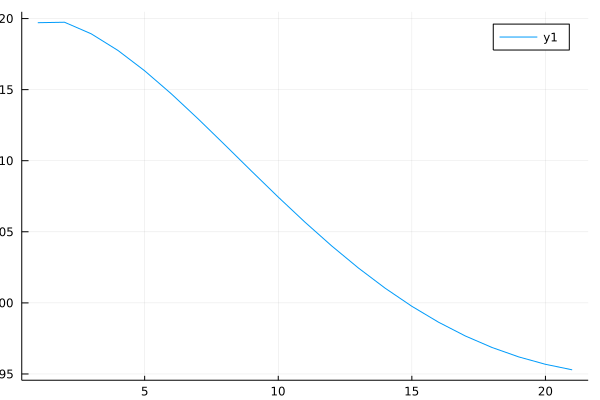

In [8]:
filstat=joinpath(rundir,"onestat.txt")
run(pipeline(`grep dynstat_theta_mean $(fileout)`,filstat))

tmp0 = read(filstat,String)
tmp0 = split(tmp0,"\n")
Tmean=[parse(Float64,split(tmp0[i],"=")[2]) for i in 1:length(tmp0)-1]
p=plot(Tmean,frmt=:png)

## Plot Results

As models run through time, they typically output snapshots and/or time-averages of state variables in `binary` or `netcdf` format for example. Afterwards, or even while the model runs, one can reread this output. Here, for example, we plot the temperature map after 20 time steps (`T.0000000020`) this way by using the convenient [MITgcmTools.jl](https://gaelforget.github.io/MITgcmTools.jl/dev/) and [MeshArrays.jl](https://juliaclimate.github.io/MeshArrays.jl/dev/) packages which simplify the handling of files and data.

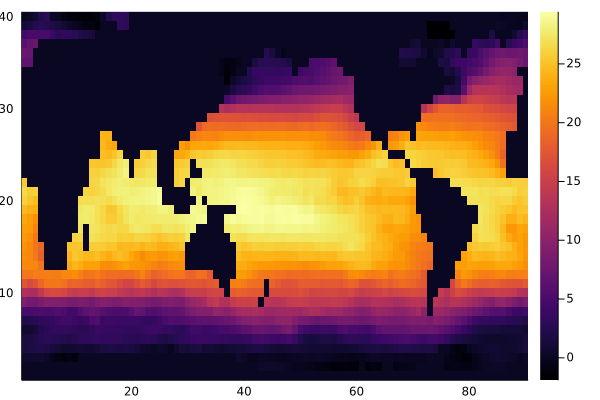

In [9]:
XC=read_mdsio(rundir,"XC"); siz=size(XC)

mread(xx::Array,x::MeshArray) = read(xx,x)
function mread(fil::String,x::MeshArray)
	d=dirname(fil)
	b=basename(fil)[1:end-5]
	read(read_mdsio(d,b),x)
end

γ=gcmgrid(rundir,"PeriodicChannel",1,fill(siz,1), [siz[1] siz[2]], eltype(XC), mread, write)
Γ=GridLoad(γ)
T=read_mdsio(rundir,"T.0000000020")
h=heatmap(T[:,:,1]',frmt=:png)

## Workflow Outline

_ClimateModels.jl_ additionally supports workflow documentation using `git`. Here we summarize this workflow's record.

In [10]:
git_log_show(MC)

5-element Vector{String}:
 "2d0b3ee initial setup"
 "f5d0663 initial tracked_parameters.toml"
 "8797479 add files in `tracked_parameters/` to git"
 "54f562e task started [1b5dcd30-8a93-4610-92c3-9ea0ae38360c]"
 "c38d48a (HEAD -> main) task ended   [1b5dcd30-8a93-4610-92c3-9ea0ae38360c]"

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*